# Spam Detection Using Unsupervised Machine Learning Techniques

https://github.com/rrazz247/spam-detection

### Problem Description

The goal of this project is to use unsupervised machine learning techniques to categorize SMS text messages as either being spam or not spam. I downloaded the dataset from kaggle:

https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset/data

This is a simple dataset that only contains two columns: the text and the label. Since this is an unsupervised binary classification task, I will not use the label information during the training--I will only use it to evaluate the models. There are 5,572 total entries in this dataset.

### Exploratory Data Analysis

First, I will load the required libraries and load the data.

In [ ]:
# Load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

In [14]:
# Load data

data = pd.read_csv("./data.csv", encoding="latin-1")

data = data[['v1', 'v2']]
data.columns = ['spam', 'text']
data['spam'] = data['spam'].map({'ham': 0, 'spam': 1})

In [15]:
data.head()

,spam,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


The below output shows that there are no missing values.

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   spam    5572 non-null   int64 
 1   text    5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


Below is a bar plot of the number of spam texts and non-spam texts. There may be a class imbalance problem here, as there are 4,825 non-spam texts to only 747 spam texts. There should be plenty of spam examples to work with, but this imbalance may become an issue later.

spam
0    4825
1     747
Name: count, dtype: int64


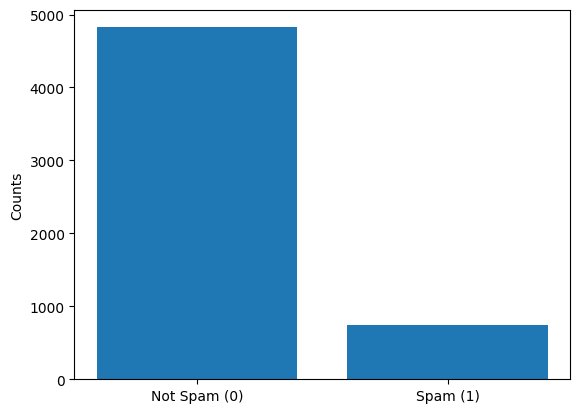

In [22]:
spam_counts = data['spam'].value_counts()
print(spam_counts)

plt.bar(spam_counts.index, spam_counts.values)
plt.ylabel("Counts")
plt.xticks(spam_counts.index, ['Not Spam (0)', 'Spam (1)'])
plt.show()

Next, I will examine the word count in each text message. The below histogram shows that almost all of the text messages have under 50 words, and most of those have less than 25. There is an outlier text that has 171 words.

171


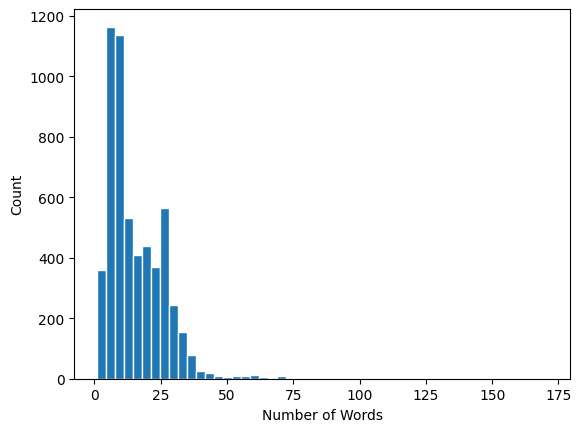

In [28]:
data['word_count'] = data['text'].apply(lambda x: len(x.split()))

print(data['word_count'].max())

plt.hist(data['word_count'], bins=50, edgecolor='white')
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.show()

Below I overlaid word count histograms for spam messages and non-spam messages. The center of the spam histogram is clearly shifted right compared to the non-spam, so spam messages tend to be longer than non-spam messages.

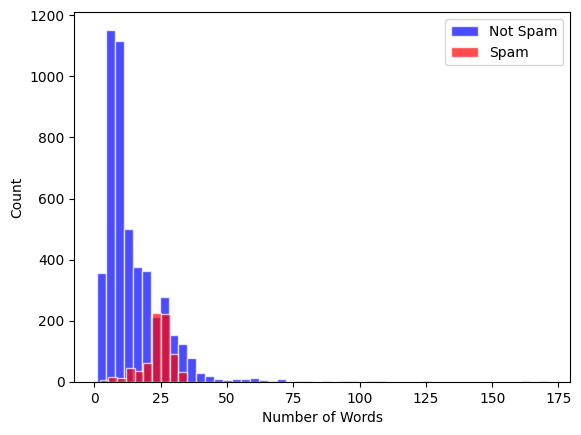

In [32]:
nospam_counts = data[data['spam'] == 0]['word_count']
spam_counts = data[data['spam'] == 1]['word_count']

plt.hist(nospam_counts, bins=50, color='blue', label='Not Spam', edgecolor='white', alpha=0.7)
plt.hist(spam_counts, bins=10, color='red', label='Spam', edgecolor='white', alpha=0.7)
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.legend()
plt.show()

### Analysis

First, I will split the data into train and test sets at an 80/20 ratio.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['spam'], test_size=0.2, random_state=123)

Raw text cannot be fed directly into a machine learning algorithm. It will first need to be processed to extract the word features, i.e. convert the data into a usable format. One high performing and popular method for text feature extraction is term frequency-inverse document frequency (TF-IDF). The TF-IDF score for a given word is the product of the TF and IDF, equations shown below:


$$
TF(t,d) = \frac{\text{Number of times term t appears in document d}}{\text{Total number of terms in document d}}
$$

$$
IDF(t,D) = log \frac{\text{Total number of documents D}}{\text{Number of documents containing term t}}
$$

TF-IDF attempts to measure the relative importance of words in the broader context of a collection of documents. It is a useful technique because it is able to identify unique and important terms that may be useful in buiilding the model later.

In [54]:
tfidf = TfidfVectorizer(stop_words='english')

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(4457, 7419)
(1115, 7419)


The above output shows the shape of the TF-IDF matrices for the train and test datasets. The train set has 4,457 rows (text messages) and 7,419 words (features) that have been assigned TF-IDF scores.

To get a sense of what words the TF-IDF vectorizer found important, I averaged the TF-IDF score for each word and displayed the mean in the bar plot below.

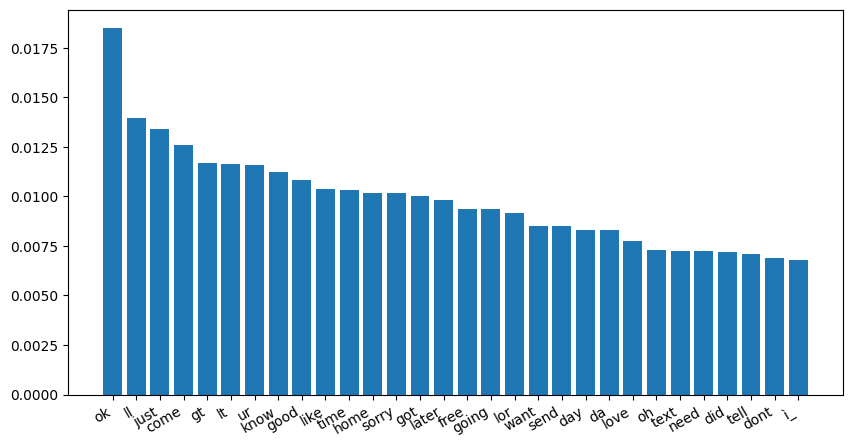

In [55]:
mean_tfidf_scores = np.asarray(X_train_tfidf.mean(axis=0)).flatten()
tfidf_df = pd.DataFrame({'word': tfidf.get_feature_names_out(), 'mean_tfidf': mean_tfidf_scores})
tfidf_df = tfidf_df.sort_values(by='mean_tfidf', ascending=False)
top30 = tfidf_df.head(30)

plt.figure(figsize=(10, 5))
plt.bar(top30['word'], top30['mean_tfidf'])
plt.xticks(rotation = 30, ha = 'right')
plt.show()

The highest scoring word is 'ok', which makes sense as it is a response to something. It's hard to imagine a scammer using the word 'ok' in a spam message. Of the top 30 words, the one that I think would be most associated with spam messages is 'free', as scammers often try to convince people that they'll get something for free.

Now that the text features have been extracted, we can move on to clustering. Here I will use K-means clustering, because it is a simple algorithm and allows me to set `n_clusters=2`, because this is a binary classification problem and more than two clusters would not make sense.

In [56]:
kmeans = KMeans(n_clusters=2, random_state=123)

kmeans.fit(X_train_tfidf)

KMeans(n_clusters=2, random_state=123)

0.857751851020866


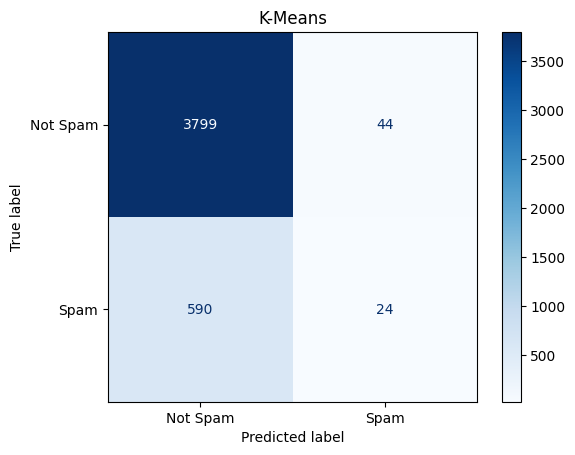

In [68]:
train_cluster_labels = kmeans.predict(X_train_tfidf)
train_mapped_labels = np.where(train_cluster_labels == 1, 0, 1)

accuracy = accuracy_score(y_train, train_mapped_labels)

print(accuracy)

cm = confusion_matrix(y_train, train_mapped_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Spam', 'Spam'])
disp.plot(cmap='Blues')
plt.title("K-Means")
plt.show()

This initial model has an accuracy of 0.858, but has very limited positive prediction value, as it was only able to correctly classify 24 out of 614 spam messages.

### Results

To try and improve this K-means model, I will perform a dimensionality reduction step using PCA. This should help to convert the sparse and high dimensional TF-IDF matrix into something more information-rich. Below I chose to reduce the data to 10 principal components.

In [108]:
pca = PCA(n_components=10, random_state=123)

X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_pca = pca.transform(X_test_tfidf.toarray())

Now I fit the K-Means model to this newly dimension-reduced train dataset.

In [109]:
kmeans = KMeans(n_clusters=2, random_state=123)
kmeans.fit(X_train_pca)

KMeans(n_clusters=2, random_state=123)

0.8276867848328472


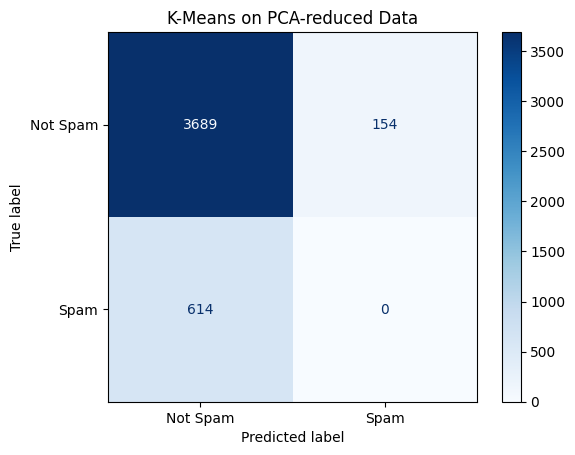

In [110]:
train_cluster_labels = kmeans.predict(X_train_pca)

train_mapped_labels = np.where(train_cluster_labels == 1, 1, 0)

accuracy = accuracy_score(y_train, train_mapped_labels)

print(accuracy)

cm = confusion_matrix(y_train, train_mapped_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Spam', 'Spam'])
disp.plot(cmap='Blues')
plt.title("K-Means on PCA-reduced Data")
plt.show()

Unfortunately, this did not improve the model at all, as the accuracy dropped to 0.828, and more importantly, the model was unable to correctly identify even a single spam text message. This model predicted slightly more spam messages, but none of them were truly spam messages. The model must be picking up on something other than the inherent "spamminess" of these text messages.

Instead of trying additional dimensionality reduction techniques, I will go back to the original K-means model and try to tweak some parameters to improve the performance. Below, I increased `n_init` to 100. K-means runs multiple times with different initial centroids and selects the best result. Increasing `n_init` might improve performance at the cost of longer runtime, but that increase is negligible as the dataset is fairly small. I also increased `max_iter` to 1000 to ensure that the clustering converges properly.

In [100]:
kmeans = KMeans(n_clusters=2, n_init=100, max_iter=1000, random_state=123)
kmeans.fit(X_train_tfidf)

KMeans(max_iter=1000, n_clusters=2, n_init=100, random_state=123)

0.827462418667265


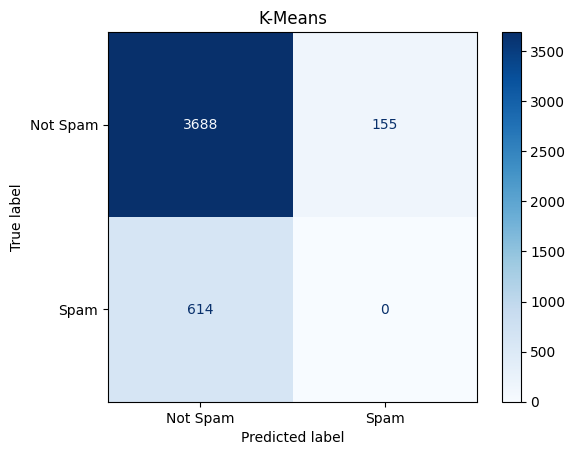

In [101]:
train_cluster_labels = kmeans.predict(X_train_tfidf)
train_mapped_labels = np.where(train_cluster_labels == 1, 1, 0)

accuracy = accuracy_score(y_train, train_mapped_labels)

print(accuracy)

cm = confusion_matrix(y_train, train_mapped_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Spam', 'Spam'])
disp.plot(cmap='Blues')
plt.title("K-Means")
plt.show()

These changes ended up making the model worse, as this model does not correctly predict any spam messages.

So, it turns out that the original K-means model with default settings performed best. Below I use that original model to make predictions on the unseen test data.

In [105]:
kmeans = KMeans(n_clusters=2, random_state=123)

kmeans.fit(X_train_tfidf)

KMeans(n_clusters=2, random_state=123)

0.8834080717488789


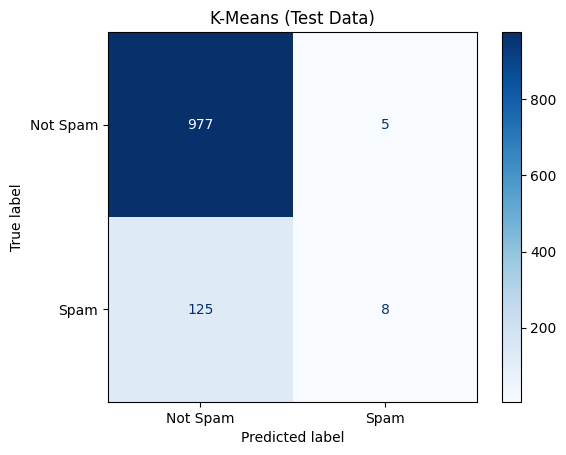

In [107]:
test_cluster_labels = kmeans.predict(X_test_tfidf)
test_mapped_labels = np.where(test_cluster_labels == 1, 0, 1)

accuracy = accuracy_score(y_test, test_mapped_labels)

print(accuracy)

cm = confusion_matrix(y_test, test_mapped_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Spam', 'Spam'])
disp.plot(cmap='Blues')
plt.title("K-Means (Test Data)")
plt.show()

With only 8 spam messages correctly identified out of 133, this model performs similarly on the test data compared to how it did on the train data. That is to say, not well.

### Conclusions

The goal of this project was to build an unsupervised model that is able to correctly identify spam text messages. Unfortunately, I was not successful in that regard. My best model used K-means clustering on TF-IDF vectorized text data. Although it yielded a seemingly high accuracy of 0.883 on the test data, this value is misleading, because the model was only able to correctly classify 8 spam messages out of a total of 133 in the test dataset. The model is barely better than a completely naive model that simply predicts "not spam" for every message.

In the future, I would like to better address the class imbalance that I observed during the EDA stage. It is possible that by addressing this imbalance with oversampling, undersampling, or SMOTE, I could have given the model a better chance to learn features that are specific to spam messages. I would also like to experiment with different natural language processing techniques to see if they work better than the TF-IDF I utilized here.